In [1]:
import itertools as it
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset, random_split
import attention as att
import torch.optim as optim
from tqdm import trange
from matplotlib.colors import LogNorm

In [2]:
# For same initialization of weights/biases of model
torch.manual_seed(seed=999)
torch.set_float32_matmul_precision('high')

In [3]:
input_CG = np.load('/pscratch/sd/h/hbassi/2d_vlasov_data_coarse_scale_16_qtt.npy')
target_FG = np.load('/pscratch/sd/h/hbassi/2d_vlasov_data_fine_scale_128_qtt.npy') 
input_CG.shape, target_FG.shape

((80, 1, 128, 128), (80, 1, 128, 128))

In [4]:
### Define parameters in the NN 
# previous was 256 and 64
bond_dim = 512
num_heads = 64  ## bond_dim/num_heads must be a integer
num_layers = 2
input_dim = input_CG.shape[2]
output_dim = target_FG.shape[2]
print(input_dim, output_dim) 

128 128


In [5]:
vit_model_regression = att.VisionTransformer(
    img_height=input_dim,        # Image height
    img_width=input_dim,       # Image width (non-square image)
    patch_size_h=5,      # Patch size for height
    patch_size_w=5,     # Patch size for width
    input_dim=1,         # 1 for single channel images
    num_heads=num_heads,         
    num_layers=num_layers,        
    bond_dim=bond_dim,        
    output_dim=output_dim**2,
    dropout = 0.1
)

In [6]:
device = 'cuda'
input_CG_tensor = torch.tensor(input_CG, dtype=torch.float32).to(device)
target_FG_tensor = torch.tensor(target_FG, dtype=torch.float32).to(device)

In [7]:
# Create the full dataset
dataset = TensorDataset(input_CG_tensor[:70], target_FG_tensor[:70])

# 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [8]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(vit_model_regression.parameters(), lr=0.001)

In [9]:
# Training loop
num_epochs = 2000

In [10]:
vit_model_regression = vit_model_regression.to(device)
vit_model_regression = torch.compile(vit_model_regression)

In [11]:
for epoch in trange(num_epochs):
    vit_model_regression.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_dataloader):
        output = vit_model_regression(data)
        target_flat = target.view(-1, output_dim * output_dim)
        output = output.view(-1, output_dim* output_dim)
        #print(target_flat.shape, output.shape)
        loss = criterion(output, target_flat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.8f}')

        # Validation phase
        vit_model_regression.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_dataloader:
                output = vit_model_regression(data)
                target_flat = target.view(-1, output_dim * output_dim)
                output = output.view(-1, output_dim* output_dim)
                loss = criterion(output, target_flat)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_dataloader):.8f}')
        print('=============================================================================')


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [1/2000], Loss: 0.03196153


  0%|          | 2/2000 [00:42<9:50:21, 17.73s/it] 

Validation Loss: 0.01772153


  5%|▌         | 102/2000 [00:55<04:02,  7.81it/s]

Epoch [101/2000], Loss: 0.00446887
Validation Loss: 0.00679875


 10%|█         | 202/2000 [01:08<03:50,  7.79it/s]

Epoch [201/2000], Loss: 0.00326495
Validation Loss: 0.00669599


 15%|█▌        | 302/2000 [01:20<03:37,  7.81it/s]

Epoch [301/2000], Loss: 0.00257940
Validation Loss: 0.00771114


 20%|██        | 402/2000 [01:33<03:24,  7.81it/s]

Epoch [401/2000], Loss: 0.00173342
Validation Loss: 0.00791188


 25%|██▌       | 502/2000 [01:46<03:11,  7.82it/s]

Epoch [501/2000], Loss: 0.00154328
Validation Loss: 0.00800852


 30%|███       | 602/2000 [01:58<02:58,  7.82it/s]

Epoch [601/2000], Loss: 0.00129945
Validation Loss: 0.00777733


 35%|███▌      | 702/2000 [02:11<02:46,  7.82it/s]

Epoch [701/2000], Loss: 0.00121997
Validation Loss: 0.00790562


 40%|████      | 802/2000 [02:23<02:33,  7.82it/s]

Epoch [801/2000], Loss: 0.00657935
Validation Loss: 0.01234262


 45%|████▌     | 902/2000 [02:36<02:20,  7.80it/s]

Epoch [901/2000], Loss: 0.00106706
Validation Loss: 0.00797780


 50%|█████     | 1002/2000 [02:49<02:07,  7.82it/s]

Epoch [1001/2000], Loss: 0.00079947
Validation Loss: 0.00810223


 55%|█████▌    | 1102/2000 [03:01<01:54,  7.82it/s]

Epoch [1101/2000], Loss: 0.00101808
Validation Loss: 0.00794982


 60%|██████    | 1202/2000 [03:14<01:42,  7.82it/s]

Epoch [1201/2000], Loss: 0.00100299
Validation Loss: 0.00811503


 65%|██████▌   | 1302/2000 [03:27<01:29,  7.82it/s]

Epoch [1301/2000], Loss: 0.00094939
Validation Loss: 0.00797854


 70%|███████   | 1402/2000 [03:39<01:17,  7.76it/s]

Epoch [1401/2000], Loss: 0.00084507
Validation Loss: 0.00800632


 75%|███████▌  | 1502/2000 [03:52<01:03,  7.81it/s]

Epoch [1501/2000], Loss: 0.00083095
Validation Loss: 0.00806334


 80%|████████  | 1602/2000 [04:05<00:50,  7.82it/s]

Epoch [1601/2000], Loss: 0.00126497
Validation Loss: 0.00798648


 85%|████████▌ | 1702/2000 [04:17<00:38,  7.83it/s]

Epoch [1701/2000], Loss: 0.00088505
Validation Loss: 0.00773113


 90%|█████████ | 1802/2000 [04:30<00:25,  7.82it/s]

Epoch [1801/2000], Loss: 0.00082586
Validation Loss: 0.00776261


 95%|█████████▌| 1902/2000 [04:43<00:12,  7.80it/s]

Epoch [1901/2000], Loss: 0.00077911
Validation Loss: 0.00783278


100%|██████████| 2000/2000 [04:56<00:00,  6.75it/s]


In [39]:
input_CG_test = input_CG[70:]  
target_FG_test = target_FG[70:]  

In [40]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [41]:
vit_model_regression.eval().cpu()

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (linear_proj): Linear(in_features=25, out_features=512, bias=True)
    )
    (transformer): TransformerEncoderViT(
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_linear): Linear(in_features=512, out_features=512, bias=False)
            (k_linear): Linear(in_features=512, out_features=512, bias=False)
            (v_linear): Linear(in_features=512, out_features=512, bias=False)
            (out): Linear(in_features=512, out_features=512, bias=True)
          )
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (fc_out): Linear(in_features=512, out_features=16384, bias=False)
    )
  )
)

In [42]:
predictions = []
targets = []
inputs = []  

with torch.no_grad():
    batch_size = 64
    for i in range(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]

       
        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = vit_model_regression(data)  
     
        #print(f"Output shape before reshaping: {output.shape}")

        output = output.view(output.shape[0], 1, output_dim, output_dim)  

       
        predictions.append(output.numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy())  
 

In [43]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

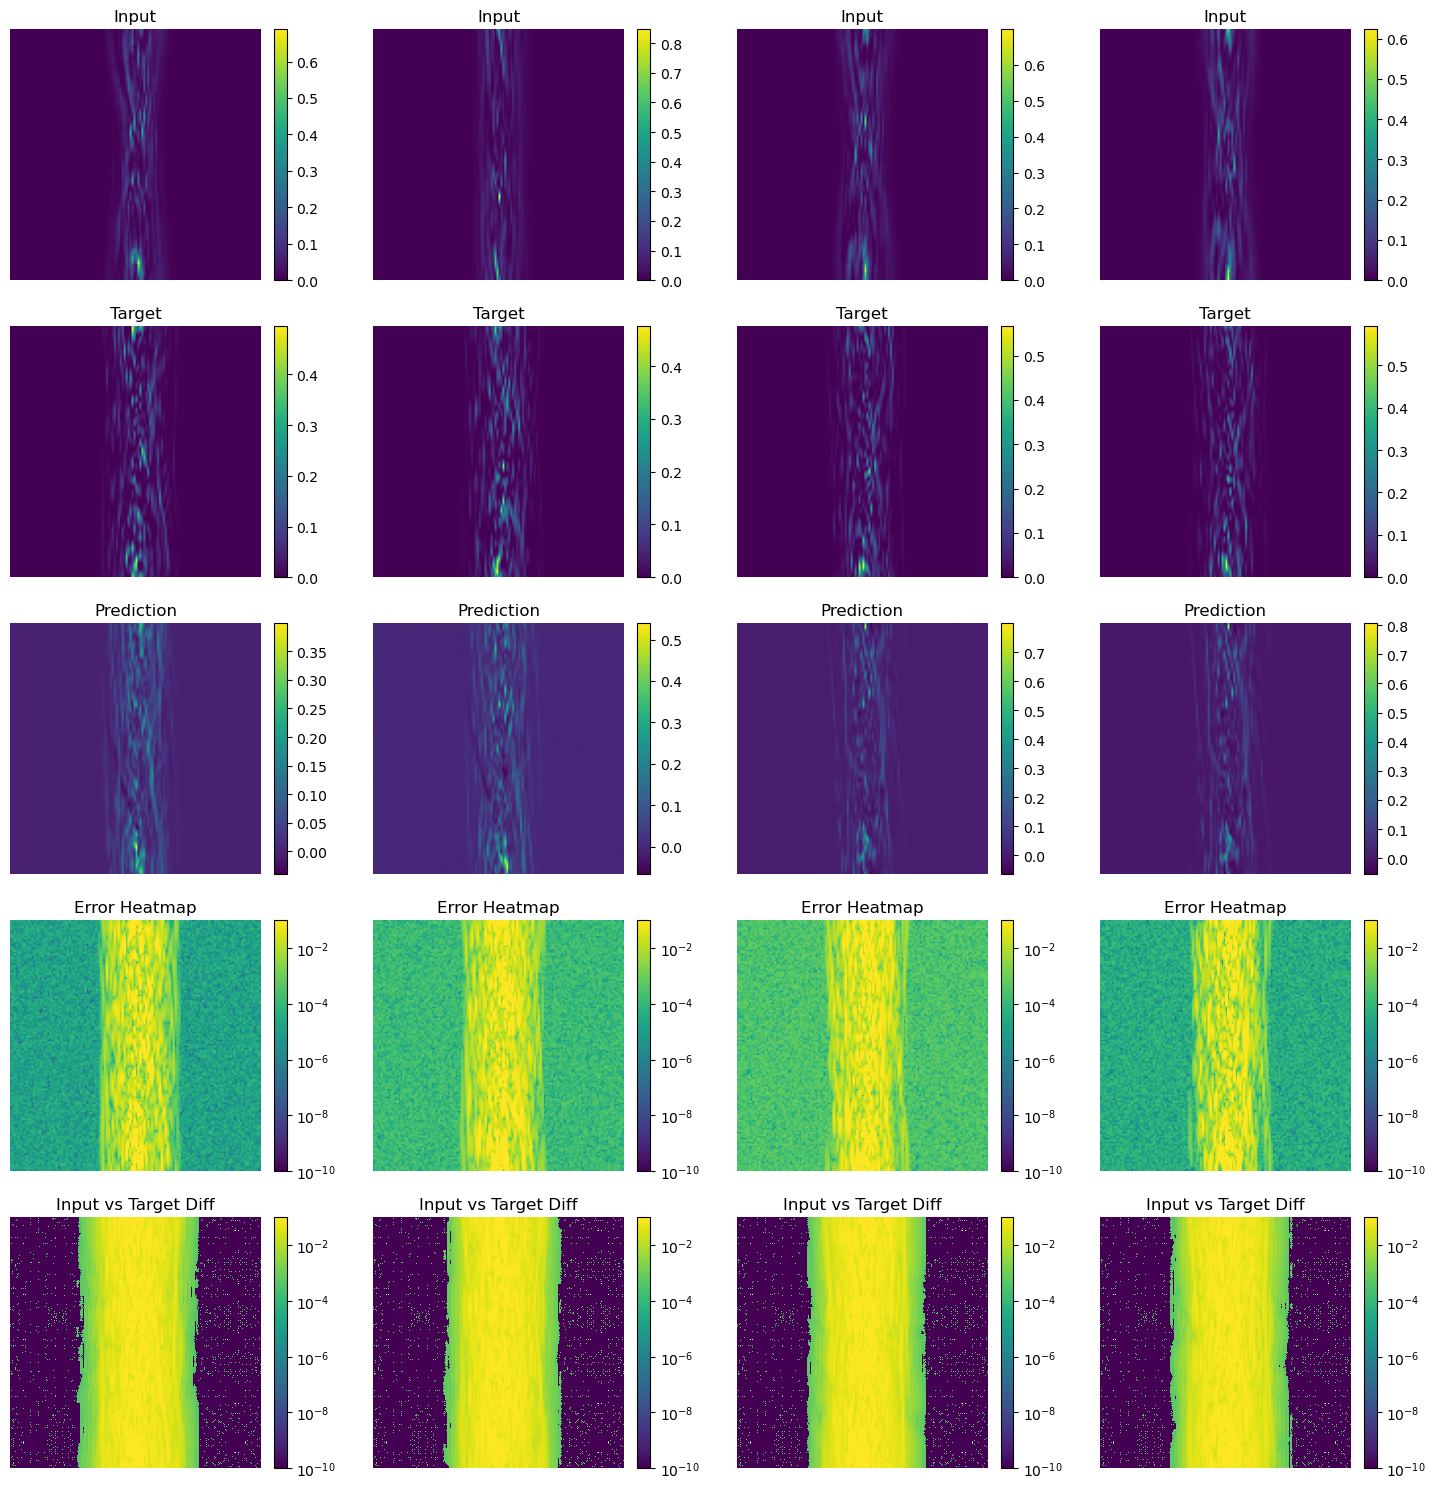

In [44]:
num_samples = 4  # Number of samples to visualize
indices = np.random.choice(len(predictions), num_samples, replace=False)

plt.figure(figsize=(15, 15))  # Adjusted figure size for additional row
for i, idx in enumerate(indices):
    # Plot the input
    ax = plt.subplot(5, num_samples, i + 1)
    im = ax.imshow(inputs[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Input')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input

    # Plot the target
    ax = plt.subplot(5, num_samples, i + 1 + num_samples)
    im = ax.imshow(targets[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Target')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for target

    # Plot the prediction
    ax = plt.subplot(5, num_samples, i + 1 + 2 * num_samples)
    im = ax.imshow(predictions[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for prediction

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for error heatmap

    # Plot the absolute difference between the input and target
    input_target_diff = np.abs(inputs[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 4 * num_samples)
    im = ax.imshow(input_target_diff, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Input vs Target error
    plt.title('Input vs Target Diff')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input vs target diff

plt.tight_layout()
#plt.savefig('vit_GS_model_training_result_blurred.png')


In [46]:
input_CG_test = input_CG[:70]  
target_FG_test = target_FG[:70]

In [47]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [48]:
vit_model_regression.eval()

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (linear_proj): Linear(in_features=25, out_features=512, bias=True)
    )
    (transformer): TransformerEncoderViT(
      (layers): ModuleList(
        (0-1): 2 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_linear): Linear(in_features=512, out_features=512, bias=False)
            (k_linear): Linear(in_features=512, out_features=512, bias=False)
            (v_linear): Linear(in_features=512, out_features=512, bias=False)
            (out): Linear(in_features=512, out_features=512, bias=True)
          )
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (fc_out): Linear(in_features=512, out_features=16384, bias=False)
    )
  )
)

In [49]:
predictions = []
targets = []
inputs = []  

In [50]:
with torch.no_grad():
    batch_size = 64
    for i in range(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]


        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = vit_model_regression(data) 
    
        #print(f"Output shape before reshaping: {output.shape}")
        output = output.view(output.shape[0], 1, output_dim, output_dim)  

        
        predictions.append(output.numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy()) 

In [51]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

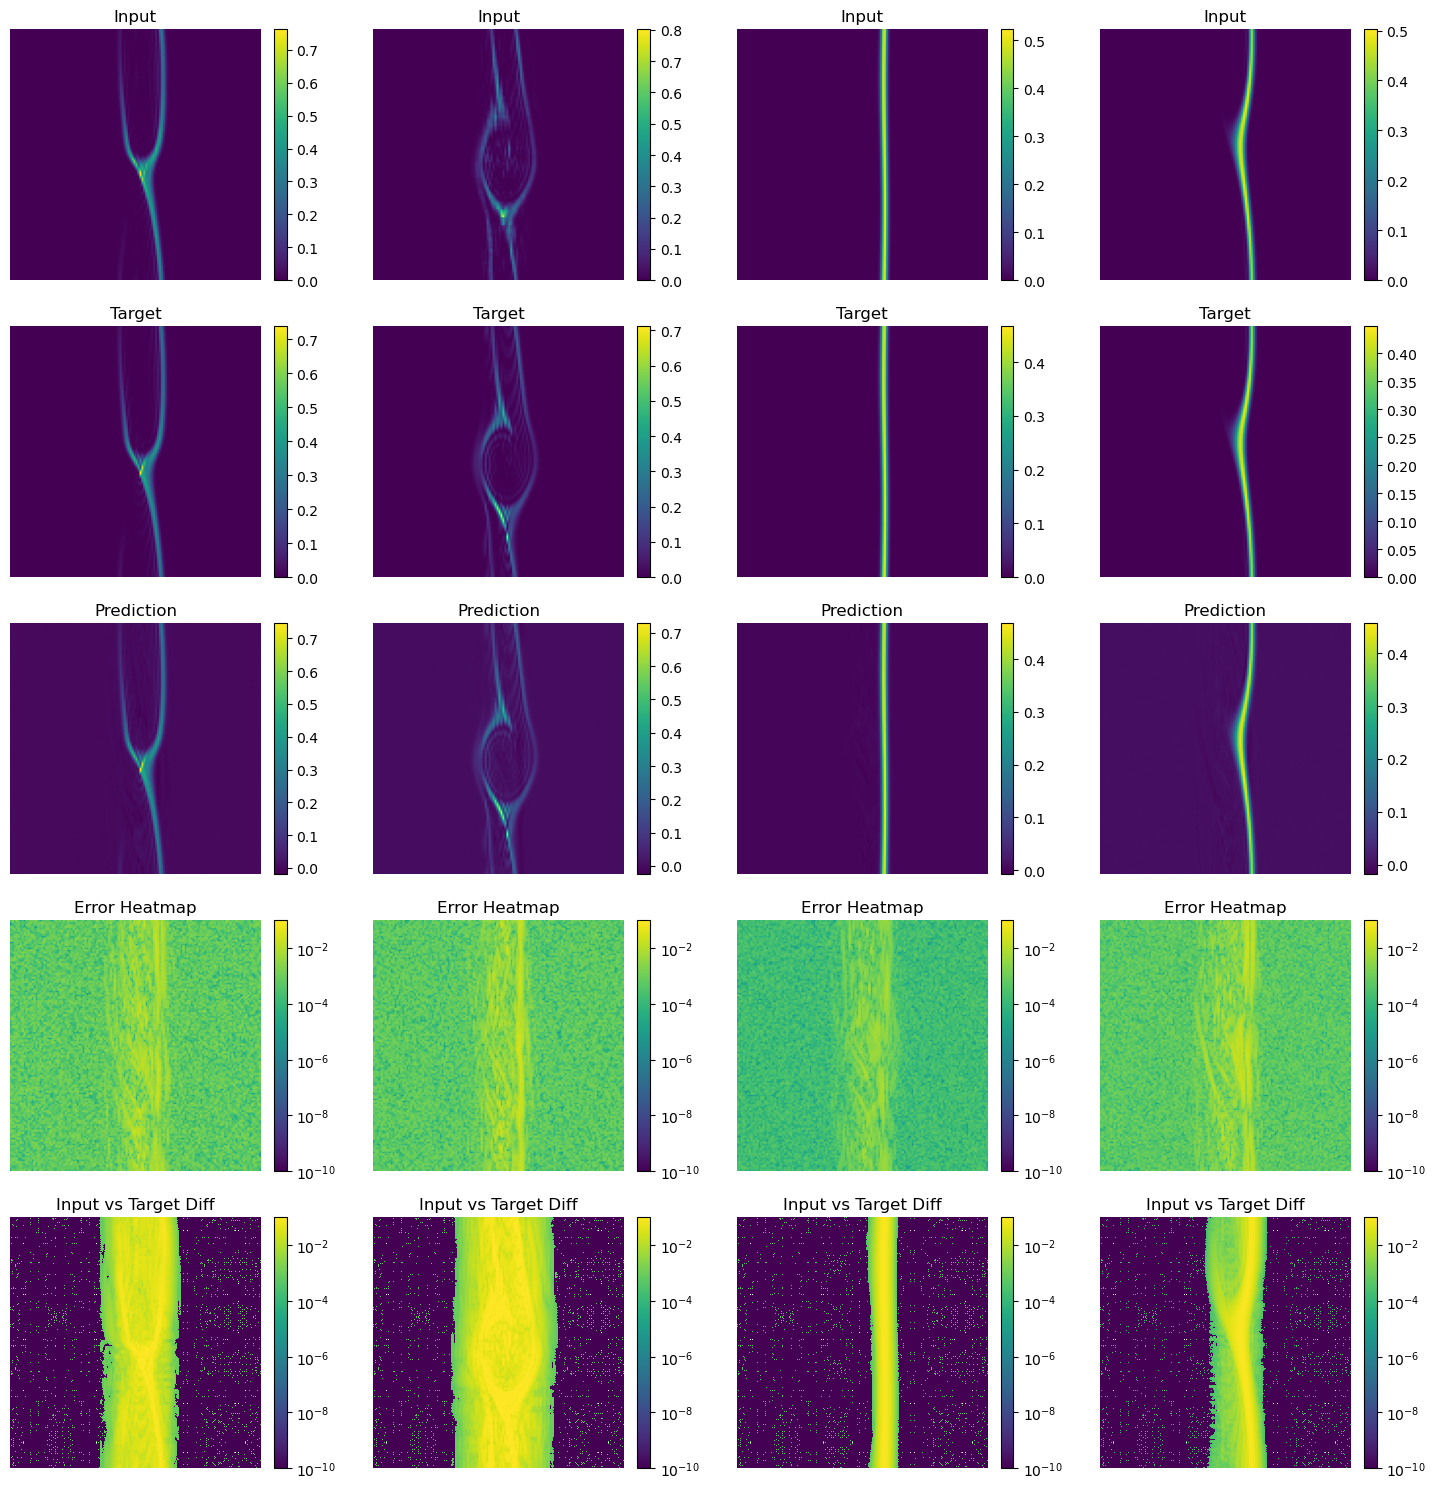

In [55]:
num_samples = 4  # Number of samples to visualize
indices = np.random.choice(len(predictions), num_samples, replace=False)

plt.figure(figsize=(15, 15))  # Adjusted figure size for additional row
for i, idx in enumerate(indices):
    # Plot the input
    ax = plt.subplot(5, num_samples, i + 1)
    im = ax.imshow(inputs[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Input')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input

    # Plot the target
    ax = plt.subplot(5, num_samples, i + 1 + num_samples)
    im = ax.imshow(targets[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Target')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for target

    # Plot the prediction
    ax = plt.subplot(5, num_samples, i + 1 + 2 * num_samples)
    im = ax.imshow(predictions[idx, 0], cmap='viridis')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for prediction

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for error heatmap

    # Plot the absolute difference between the input and target
    input_target_diff = np.abs(inputs[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 4 * num_samples)
    im = ax.imshow(input_target_diff, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Input vs Target error
    plt.title('Input vs Target Diff')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input vs target diff

plt.tight_layout()
#plt.savefig('vit_GS_model_training_result_blurred.png')
